# AEMO Redux - Paul Cronin

## PART I - DATA, MODELS & ANALYSIS

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import itertools
from dateutil.parser import parse

from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

from numpy.random import seed
seed(1)

### Load raw data and parse dates

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import raw data & parse dates
dateparse=lambda dates:parse(dates)
dtypes = {'STATE':'str',            # One of 4 states: QLD, NSW, SA & VIC
          'DATETIME':'str',         # The date and time of the reading
          'TOTALDEMAND':'float',    # The KNOWN needed energy at that time
          'POWER':'float',          # The KNOWN photovoltaic power at that time
          'LOCATION':'str',         # Location within each state (unused)
          'TEMPERATURE':'float',    # The KNOWN temperature at that time
          'FORECASTDEMAND':'float', # The AEMO prediction for power at that time
          'Weekday':'str',          # Categorical day data (EG Monday, Tuesday)
          'Quarter':'Int32',        # Which quarter of the year (unused)
          'Month':'Int32',          # Which month of the year (unused)
          'Season':'str',           # Which season of the year (unused)
          'Day':'str',      
          'Year':'Int32',           # Which year (unused)
          'SUNRISE':'str',          # The time of sunrise that day (unused)
          'SUNSET':'str',           # The time of sunset that day (unused)
          'DAYTYPE':'str',          # The daytype
          'HOLIDAY':'boolean'       # If the day was a public holiday (boolean)
}

#df_all = pd.read_csv('dataset_v1_0.csv', sep =',',dtype=dtypes,parse_dates=['DATETIME'],date_parser=dateparse)
df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_v1_0.csv', 
                     sep =',',dtype=dtypes,parse_dates=['DATETIME'],date_parser=dateparse)


### Data Clean-up

In [4]:
# reduce dataset to period when we have solar data & remove unnecessary columns
# earliest possible: 2018-03-06 09:30:00
# latest possible: 2021-03-18 00:00:00
ts0 = (pd.Timestamp("2019-01-01 00:00:00")) # beginning of sliding window training & validation
ts1 = (pd.Timestamp("2021-01-01 00:00:00")) # end of training, & validation, beginning of testin
ts2 = (pd.Timestamp("2021-03-18 00:00:00")) # end of testing

# fills a few empty cells
df_all['POWER'].fillna( method ='ffill', inplace = True)

# dumps unused variables
to_keep_cols = ["DATETIME",'TOTALDEMAND', 'POWER', 'TEMPERATURE', 'Weekday','HOLIDAY','FORECASTDEMAND','STATE']
df_reduced = df_all[(df_all['DATETIME']>=ts0) & (df_all['DATETIME']<ts2)][to_keep_cols]

# transform DATETIME -> seconds
df_reduced['seconds'] = df_reduced['DATETIME'].map(pd.Timestamp.timestamp)

# set DATETIME as the dataframe index
df_reduced.set_index('DATETIME',inplace=True, drop=True)

# make new column - this is the total combined solar power and generated demand
df_reduced['STATEDEMAND'] = df_reduced['TOTALDEMAND'] + df_reduced['POWER']

# make new dataframe of forecast
df_reduced_forecast = df_reduced[['seconds','TOTALDEMAND', 'FORECASTDEMAND']]
df_reduced.drop(['FORECASTDEMAND'], axis=1, inplace=True)

# the state is encoded to allow separation - but will not be used for training
le = LabelEncoder()
df_reduced['STATE'] = le.fit_transform(df_reduced['STATE'])

### Feature Engineering

In [5]:
# Feature engineering
# Add daily, semi-annual and annual markers and
# transform the weekdays through one-hot encoding
# (Semi annual is important due to power demand increasing in cold & hot periods)
day = 24*60*60
year = (365.2425)*day

df_reduced['Day sin'] = np.sin(df_reduced['seconds'] * (2 * np.pi / day))
df_reduced['Day cos'] = np.cos(df_reduced['seconds'] * (2 * np.pi / day))
df_reduced['Year sin'] = np.sin(df_reduced['seconds'] * (2 * np.pi / year))
df_reduced['Year cos'] = np.cos(df_reduced['seconds'] * (2 * np.pi / year))
df_reduced['Semester sin'] = np.sin(df_reduced['seconds'] * (4 * np.pi / year))
df_reduced['Semester cos'] = np.cos(df_reduced['seconds'] * (4 * np.pi / year))

# Apply one-hot encoder to each column with categorical data
OHenc = OneHotEncoder(handle_unknown='ignore', sparse=False)

df_OneHot = pd.DataFrame(OHenc.fit_transform((df_reduced["Weekday"].to_numpy().reshape(-1, 1))))

# Re-index
df_OneHot.index = df_reduced.index

# Remove categorical columns (will replace with one-hot encoding)
df_numeric = df_reduced.drop("Weekday", axis=1)

# Add one-hot encoded columns to numerical features
df_unnorm = pd.concat([df_numeric, df_OneHot], axis=1)

### Normalization

In [6]:
# normalize the data using StandardScaler
# we could apply the scaler to each state individuallly, but it makes no diff.
scaler = StandardScaler()
fit = scaler.fit(df_unnorm)

# choose which columns are NOT going to be normalized (left as categorical variables)
norm_cols = [3,4, 13,14,15,16,17,18,19]
np.put(scaler.mean_,norm_cols,0)
np.put(scaler.var_,norm_cols,1)
np.put(scaler.scale_,norm_cols,1)

# apply modified StandardScaler to data
df_norm = pd.DataFrame(scaler.transform(df_unnorm),columns=df_unnorm.columns).apply(pd.to_numeric)

# we also apply scaler to the seconds - this is an important variable to be used
ss0 = (ts0.value /1e9-scaler.mean_[5])/scaler.scale_[5] # beginning of training & testing
ss1 = (ts1.value /1e9-scaler.mean_[5])/scaler.scale_[5] # end of training, & testing, beginning of validation
ss2 = (ts2.value /1e9-scaler.mean_[5])/scaler.scale_[5] # end of validation



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Collect all state data for processing

In [7]:
# just collect all the state data into an organized fashion for processing
states = []
for state in df_norm['STATE'].unique():
  states.append(df_norm[df_norm['STATE']==state].drop(['STATE'],axis=1))


### Train, validate, test split

In [8]:
# this is the fixed-size, sliding window.
def TrainTestSplit(train_df, test_df, train_cols, test_col):
    # this is a equal time sliding window training / validation process
    # what is called "test" here is REALLY validation.
    # There is the FINAL test data, which is segregated from this process.

    steps = 192 #this is the number of half hour increments used

    train = train_df.drop(train_df.columns[train_cols],axis=1).to_numpy(dtype=None, copy=True)
    test =  test_df.drop(  test_df.columns[train_cols],axis=1).to_numpy(dtype=None, copy=True)

    x_train = []
    y_train = []
    for i in range(steps, train.shape[0]-steps):
        x_train.append(train[i-steps:i, :])
        y_train.append(train[i, test_col])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test = []
    y_test = []
    for i in range(steps, test.shape[0]-steps):
        x_test.append(test[i-steps:i, :])
        y_test.append(test[i, test_col])
    x_test, y_test = np.array(x_test), np.array(y_test)
        
    return x_train, y_train, x_test, y_test

### Modelling

In [9]:
def ogModel(x_train, y_train, x_test, y_test):
    # the drop-out rate was chosen such that the train & validation values were approx equal
    model = Sequential()
    model.add(LSTM(units=192, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units=192, return_sequences = True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=192, return_sequences = True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=192))
    model.add(Dropout(0.1))
    model.add(Dense(units=11))
    model.add(Dense(units=1))

    return model


In [11]:
def executeModel(x_train, y_train, x_test, y_test, filename):
    epochs = 20

    model = ogModel(x_train, y_train, x_test, y_test)
#    model = ConvModel(x_train, y_train, x_test, y_test)
#    model = lstmModel(x_train, y_train, x_test, y_test)
#    model = LinModel(x_train, y_train, x_test, y_test)
    
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train.astype('f'), y_train.astype('f'), batch_size = 32, epochs = epochs)
    model.summary

    print('\n# Evaluate on test data')
    results = model.evaluate(x_test, y_test, batch_size=32)
    print('test loss, test acc:', results)

    model.save('/content/drive/MyDrive/Colab Notebooks/model no PV'+filename)

    # Please note there is a bug here to be fixed:
    # the State names are slightly mixed up.
    # this will be fixed shortly - but it is patched later on.

In [10]:
# Model choice and execution
# a number of different models were evaluated.  In the end,
# the PV AWARE MODEL and the PV UNAWARE MODEL were used.
# They are trained independently by uncommenting and re-running.

for (df, stateName) in zip(states, df_all['STATE'].unique()):
# train, validate, test split for sliding window
  train_df = df[(df['seconds']>=ss0) & (df['seconds']<ss1)]
  test_df   = df[(df['seconds']>=ss1) & (df['seconds']<ss2)]

# create the train / test splits for various testing protocols
# where DEMAND uses the historical generated DEMAND data, and INCLUDES the solar POWER data

# PV AWARE MODEL (This model simply incorportates the photovoltaic data) 
  x_train, y_train, x_test, y_test = TrainTestSplit(train_df, test_df, [5], 0)

# PV UNAWARE MODEL (This model does not incorporate photovoltaic data at all)
# x_train, y_train, x_test, y_test = TrainTestSplit(train_df, test_df, [1,5], [0])

# SECOND PV AWARE MODEL (This model incorporate the photovoltaic data more intrinsicly)
# x_train, y_train, x_test, y_test = TrainTestSplit(train_df, test_df, [0,1], 3)

  executeModel(x_train, y_train, x_test, y_test, stateName)

NameError: ignored

## PART II - Producing graphics and numerical results 

### Collect the model and AEMO predictions

102/102 [==============================] - 62s 595ms/step
VIC
102/102 [==============================] - 60s 570ms/step
SA
102/102 [==============================] - 60s 572ms/step
NSW
102/102 [==============================] - 60s 576ms/step
QLD


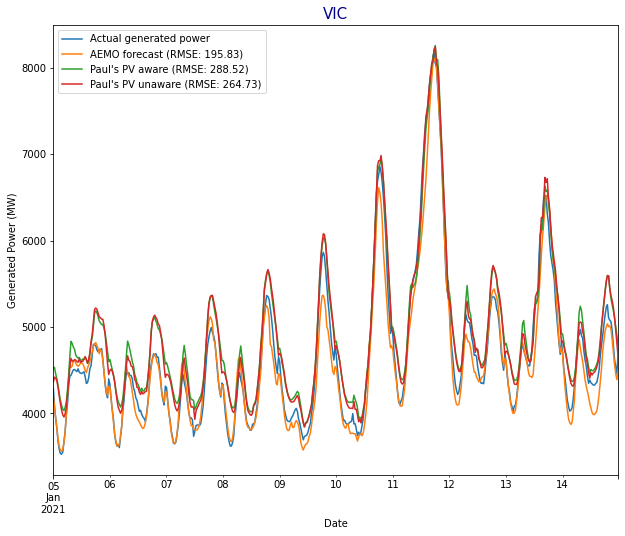

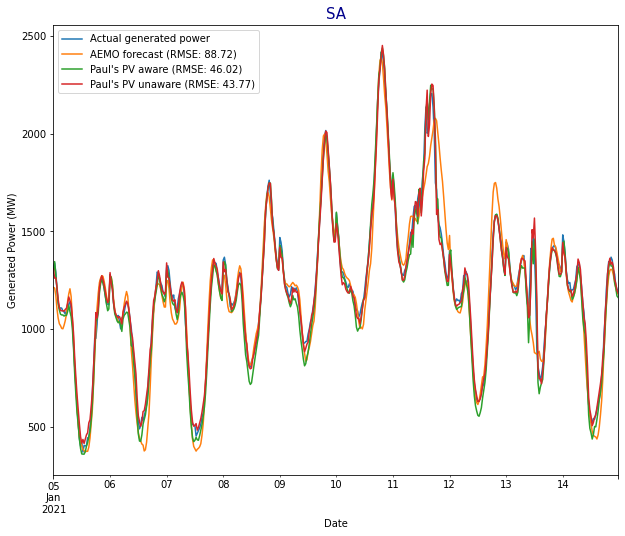

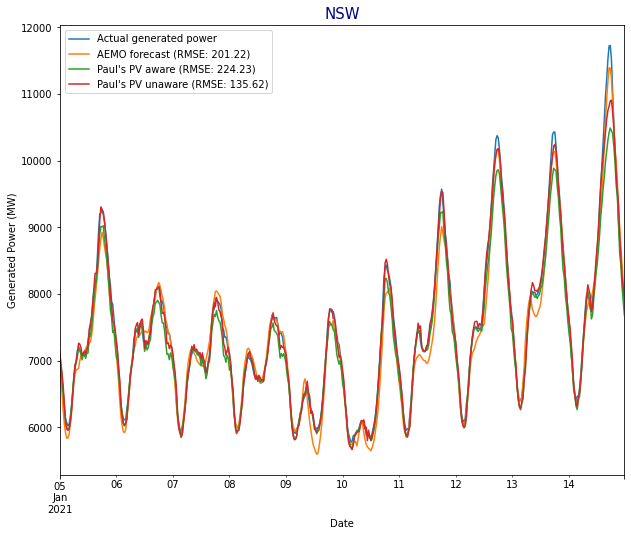

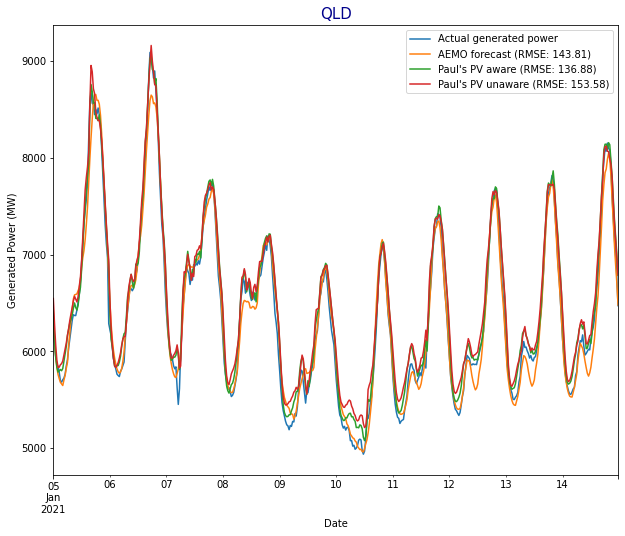

In [12]:
path = '/content/drive/MyDrive/Colab Notebooks/model '
stateNames1 = ['VIC', 'QLD','NSW','SA']
stateNames2 = ['VIC', 'SA','NSW','QLD']
# this stateNames1 / stateNames2 temporarily patches the mix-up in naming of the states
# this is a relative easy bug to be fixed

# recreate the data, only now to be used for forecasting in the testing period
to_keep_cols = ["DATETIME",'TOTALDEMAND','FORECASTDEMAND','STATE']
df_remodel = df_all[(df_all['DATETIME']>=ts1) & (df_all['DATETIME']<ts2)][to_keep_cols]

for (df, stateName1, stateName2) in zip(states, stateNames1,stateNames2):
# train, validate, test split for sliding window
  train_df = df[(df['seconds']>=ss0) & (df['seconds']<ss1)]
  test_df   = df[(df['seconds']>=ss1) & (df['seconds']<ss2)]

# load each model, and forecast the results
  modelPV = keras.models.load_model(path+stateName1)
  x_train, y_train, x_test, y_test_PV = TrainTestSplit(train_df, test_df, [5], 0)
  PV = modelPV.predict(x_test)

  modelnoPV = keras.models.load_model(path+'no PV'+stateName1)
  x_train, y_train, x_test, y_test_noPV = TrainTestSplit(train_df, test_df, [1,5], [0])
  noPV = modelnoPV.predict(x_test)

  # un-normalize the data back to initial scale
  PVunnorm = PV * scaler.scale_[0]+scaler.mean_[0]
  noPVunnorm = noPV * scaler.scale_[0]+scaler.mean_[0]

# select the correct portion of the test data to match the prediction data
# this is an artifact of the sliding window approach
  df_state = df_remodel[df_remodel['STATE']==stateName2]
  df_state = df_state.head(3456).tail(3264)
  df_state.set_index('DATETIME',inplace=True, drop=True)

# create a final 'results' datafram that contains the models, AEMO and actual data
  df_PV = pd.DataFrame(PVunnorm, columns=['with PV'], index=df_state.index)
  df_noPV = pd.DataFrame(noPVunnorm, columns=['without PV'], index=df_state.index)
  df_result = pd.concat([df_state, df_PV, df_noPV], axis=1) # ,df_recreated
  df_result.columns = ['Actual demand','AEMO model','STATE','Paul\'s PV aware model','Paul\'s PV unaware model']

# compute and print the RMSE data for each model and AEMO
  print(stateName2)
  AEMO_rmse = round(math.sqrt(mean_squared_error(df_result['Actual demand'], df_result['AEMO model'])),2)
  PV_rmse = round(math.sqrt(mean_squared_error(df_result['Actual demand'], df_result['Paul\'s PV aware model'])),2)
  noPV_rmse = round(math.sqrt(mean_squared_error(df_result['Actual demand'], df_result['Paul\'s PV unaware model'])),2)

# plot and save the data
  df_result[:480].plot(figsize = (10.12,8.27))
  plt.legend(["Actual generated power", 
              "AEMO forecast (RMSE: " + str(AEMO_rmse) + ")",
              "Paul\'s PV aware (RMSE: " + str(PV_rmse) + ")",
              "Paul\'s PV unaware (RMSE: " + str(noPV_rmse) + ")",
              ]);
  plt.xlabel('Date')
  plt.ylabel('Generated Power (MW)')
  plt.title(stateName2)
  plt.title(label=stateName2,
          fontsize=15,
          color="darkblue")
  plt.savefig(stateName2 + '.pdf',
              dpi = 600,
              format="pdf",
              orientation='landscape',
              papertype ='a4'
              )